In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST, USPS
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.distributions import MultivariateNormal

from neural_ot.data_loading import ZipLoader, get_mean_covariance, gaussian_sampler, DistributionDataset
from neural_ot.model import NeuralOT, Unflatten, Vector
from neural_ot.train import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    is_cuda = True
else:
    device = torch.device('cpu')
    is_cuda = False

In [3]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([.5], [.5]),
                               ])

In [4]:
mnist_train = MNIST('../data/mnist', download=True, transform=transform, train=True)
mnist_test = MNIST('../data/mnist', download=True, transform=transform, train=False)
mnist = ConcatDataset([mnist_train, mnist_test])

# mnist_train = MNIST('../data/mnist', download=True, transform=transforms.ToTensor(), train=True)
# mnist_test = MNIST('../data/mnist', download=True, transform=transforms.ToTensor(), train=False)

# usps_train = USPS('../data/usps', download=True, transform=transforms.ToTensor(), train=True)
# usps_test = USPS('../data/usps', download=True, transform=transforms.ToTensor(), train=False)

In [5]:
BATCH_SIZE = 300
N_BATCHES_PER_EPOCH = 10

In [11]:
MNIST_MEAN, MNIST_COV = get_mean_covariance(mnist)

100%|██████████| 70000/70000 [00:05<00:00, 12027.73it/s]


In [12]:
batch_generator = lambda : zip(gaussian_sampler(MNIST_MEAN, MNIST_COV, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH),
                               ZipLoader(mnist, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH, pin_memory=is_cuda))

In [13]:
for (x_idx, x), (y_idx, y) in batch_generator():
    print(x_idx, x.shape, y_idx.shape, y.shape)
    break

/nmnt/media/home/migonch/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `gaussian_sampler` is deprecated!
  """Entry point for launching an IPython kernel.


None torch.Size([300, 1, 28, 28]) torch.Size([300]) torch.Size([300, 1, 28, 28])


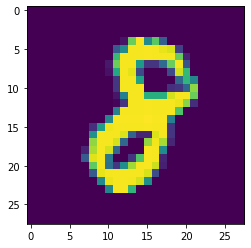

In [14]:
plt.imshow(y[0, 0].numpy())

In [15]:
source_dual_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1),
    nn.Flatten(start_dim=0)
)

target_dual_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1),
    nn.Flatten(start_dim=0)
)

# target_dual_net = Vector(initial=1e-2 * torch.randn(len(mnist)))

source_to_target_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 28 * 28),
    Unflatten(28, 28),
    nn.Tanh()
)

In [18]:
# ot = torch.load('../generative_model.pth')
ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
              regularization_mode='l2', regularization_parameter=0.05, 
              from_discrete=False, to_discrete=False).to(device)

In [341]:
plan_optimizer = Adam(ot.parameters(), lr=1e-3)
plan_scheduler = MultiStepLR(plan_optimizer, [20, 75])

In [342]:
losses = train(ot.plan_criterion, plan_optimizer, batch_generator, n_epochs=1000, device=device, 
               scheduler=plan_scheduler)

100%|██████████| 1000/1000 [21:09<00:00,  1.27s/it]


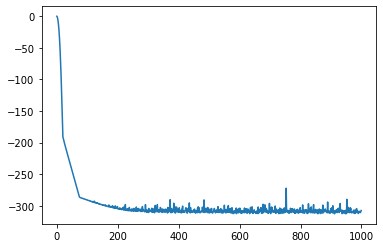

In [343]:
plt.plot(losses)

In [380]:
mapping_optimizer = Adam(ot.parameters(), lr=1e-4)
mapping_scheduler = None # MultiStepLR(plan_optimizer, [10])

In [381]:
mapping_losses = train(ot.mapping_criterion, mapping_optimizer, batch_generator, n_epochs=1000, device=device, 
                       scheduler=mapping_scheduler)

100%|██████████| 1000/1000 [23:44<00:00,  1.42s/it]


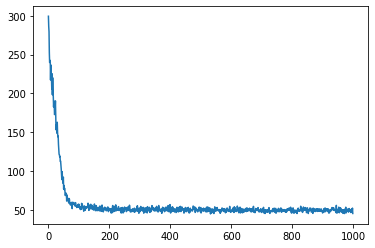

In [382]:
plt.plot(mapping_losses)

In [21]:
_, x = next(gaussian_sampler(MNIST_MEAN, MNIST_COV, batch_size=100, n_batches=1))
x = x.to(device)
mapped = ot.map(x)
imgs = mapped[:, 0].detach().cpu().numpy()

/nmnt/media/home/migonch/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `gaussian_sampler` is deprecated!
  """Entry point for launching an IPython kernel.


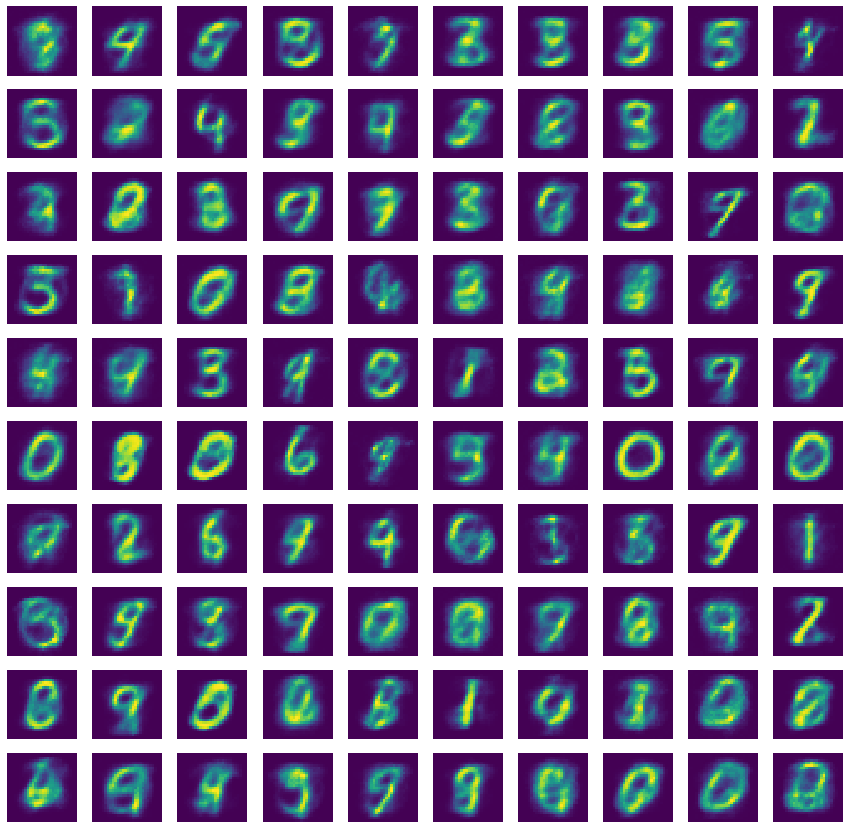

In [22]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax = axes[i // 10, i % 10]
    ax.imshow(img)
    ax.axis('off')

In [385]:
torch.save(ot, '../generative_model.pth')